### This is a synthetic parameter estimation experiment of the L96 model, using Global Bayesian Optimization with Expected Improvement.
* The dimension of the parameter space is 1.
* The initial condition is known.
* There is no additive noise.

In [1]:
import sys
sys.path.insert(0, '/Users/lunderman/Documents/GitHub/LMP19')
import LMP19
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF,WhiteKernel

In [2]:
nDim = 1

In [3]:
nSteps = 500

nK = 40
L96 = LMP19.Models.L96_1(nK=nK)
F = 10

L96.traj = L96.get_data(theta=F,nSteps=nSteps,dt=0.01)

In [4]:
lb , ub = [0],[20]
bounds = np.array([lb,ub]).T

In [5]:
def J(theta):
    _res = L96.get_data(theta=theta,x0=L96.traj[:,0],nSteps=nSteps,dt=0.01)
    return(-np.linalg.norm(_res.ravel()-L96.traj.ravel()))

In [6]:
nPts = 20
X = np.random.uniform(lb,ub,(nPts,nDim))
y = np.zeros((nPts,1))
for kk in range(nPts):
    y[kk,0]= J(X[kk,:])

In [7]:
GBO = LMP19.GBO(J,nDim,X,y,bounds)

kernel = 1.0**2*RBF(np.var(X))+1.0**2*WhiteKernel(np.std(y))
GP = GPR(kernel = kernel,normalize_y=False,n_restarts_optimizer=50).fit(X,y)

In [8]:
nIter = 10
GBO.GP = GP
for kk in range(nIter):
    GBO.Expected_Improvement()

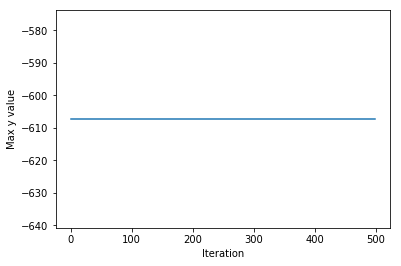

In [9]:
plt.plot(np.arange(nSteps),[np.max(GBO.y[:nPts+kk,0]) for kk in range(nSteps)])
plt.ylabel('Max y value')
plt.xlabel('Iteration')
plt.show()

In [10]:
_res = L96.get_data(theta=GBO.X[np.argmax(GBO.y[:nPts+kk,0]),:],x0=L96.traj[:,0],nSteps=nSteps,dt=0.01)

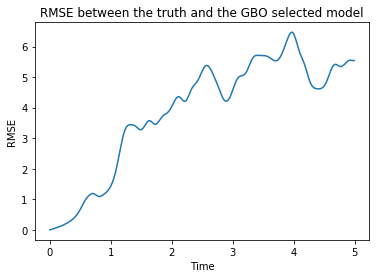

In [11]:
RMSE = [np.sqrt(np.mean((L96.traj[:,kk]-_res[:,kk])**2)) for kk in range(nSteps)]
plt.plot(np.arange(0,nSteps*0.01,0.01),RMSE)
plt.title('RMSE between the truth and the GBO selected model')
plt.ylabel('RMSE')
plt.xlabel('Time')
plt.show()

In [12]:
X = L96.traj
Y = _res

<IPython.core.display.Javascript object>


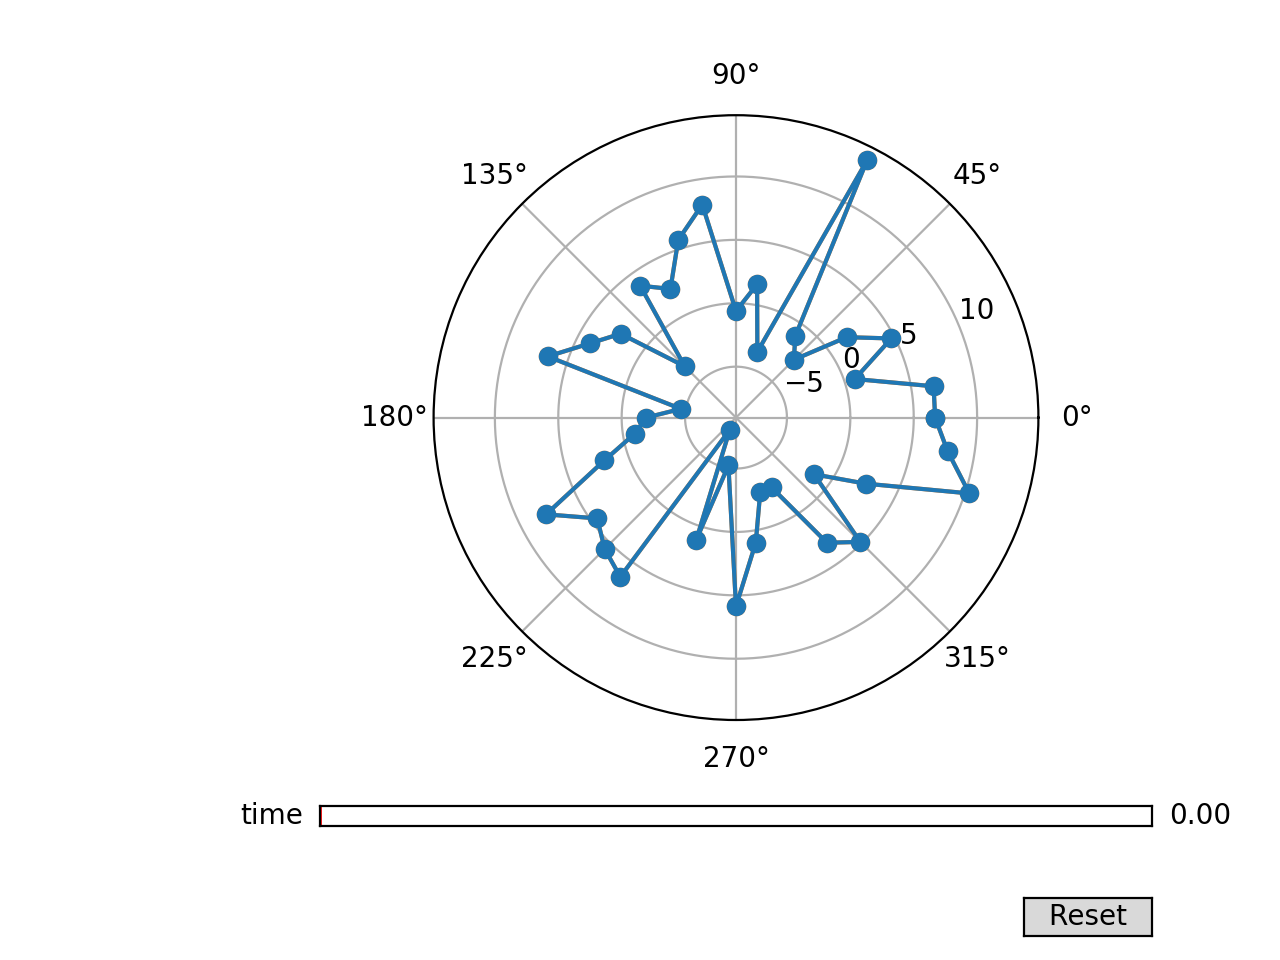

In [13]:
from matplotlib.widgets import Slider, Button, RadioButtons
%matplotlib notebook

theta_X = np.linspace(0, 2*np.pi, L96.nK+1)

def signal_X(XX,kk):
    Xplt = [val for val in XX[:,int(kk)]]+[XX[0,int(kk)]]
    return(Xplt)

fig = plt.figure()
ax = plt.subplot(111, projection='polar')


# Adjust the subplots region to leave some space for the sliders and buttons
fig.subplots_adjust(left=0.25, bottom=0.25)


# Draw the initial plot
# The 'line' variable is used for modifying the line later
[Y_line2] = ax.plot(theta_X,signal_X(Y,0),color='C1')
[Y_line1] = ax.plot(theta_X,signal_X(Y,0),'o',color='C1')

[X_line2] = ax.plot(theta_X,signal_X(X,0),color='C0')
[X_line1] = ax.plot(theta_X,signal_X(X,0),'o',color='C0')

# Add sliders for tweaking the parameters

# Define an axes area and draw a slider in it
slider_ax  = fig.add_axes([0.25, 0.14, 0.65, 0.02])
slider = Slider(slider_ax, 'time', 0, Y.shape[1], valinit=0)

# Define an action for modifying the line when any slider's value changes
def sliders_on_changed(val):
    data_X = signal_X(Y,slider.val)
    ax.set_yticks([])
    ax.set_xticks([])
    Y_line1.set_ydata(data_X)
    Y_line2.set_ydata(data_X)
    
    data_X = signal_X(X,slider.val)
    X_line1.set_ydata(data_X)
    X_line2.set_ydata(data_X)
    
    fig.canvas.draw_idle()
slider.on_changed(sliders_on_changed)

# Add a button for resetting the parameters
reset_button_ax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
reset_button = Button(reset_button_ax, 'Reset', hovercolor='0.975')
def reset_button_on_clicked(mouse_event):
    slider.reset()
reset_button.on_clicked(reset_button_on_clicked)

plt.show()

In [14]:
print("GBO selected forcing parameter:")
GBO.X[np.argmax(GBO.y[:nPts+kk,0]),:]

GBO selected forcing parameter:


array([9.29972295])